In [1]:
"""check the consistency of wRSM across subjects
"""
import os
import sys 
import numpy as np
import pandas as pd 
from sklearn.model_selection import train_test_split

import matplotlib
import matplotlib.pyplot as plt 
import seaborn as sns 

from qmvpa import utils, factor, rsa
from data_loader import load_cifar, load_mnist
from dep.utils import subset_units
from config import get_log_info

%matplotlib inline 
%autosave 5

sns.set(style = 'white', context='poster', font_scale=1, rc={"lines.linewidth": 2.5})

Using TensorFlow backend.


Autosaving every 5 seconds


In [2]:
# get roots 
log_root = '/tigress/qlu/logs/keras-resnet/log'
plt_root = '/tigress/qlu/logs/keras-resnet/plots'
pltdata_root = '/tigress/qlu/logs/keras-resnet/plots_data'

# define data name, model name 
data_name = 'cifar100'
model_name = 'resnet18'
# model_name = 'conv'

# load data 
_, _, _, _, _, labels, data_info = load_cifar(data_name)
[n_classes, img_rows, img_cols, img_channels] = data_info
n_test_egs = len(labels)

# define params 
log_info_list = get_log_info(data_name, model_name)
n_subjs, layer_selected, n_layers, log_epochs, n_log_epochs = log_info_list

print('data: %s\nmodel: %s' % (data_name, model_name))
print('log epochs', log_epochs)
print('layer selected', layer_selected)

# set relevant parameters 
n_max_units = 1000
test_size = .2 

if model_name == 'conv': 
    layer_selected = layer_selected[:-1]

data: cifar100
model: resnet18
log epochs [  0   1   2   3   5   8  13  22  36  60 100]
layer selected [2, 10, 17, 25, 32, 40, 47, 55, 62]


In [3]:
def compute_2nd_order_corrs(wRSMs_n): 
    n_subjs = np.shape(wRSMs_n)[0]
    # from itertools import product
    corr_map = np.zeros((n_subjs, n_subjs))
    pval_map = np.zeros((n_subjs, n_subjs))
    wRSMs_2nd_order_corrs = []
    wRSMs_2nd_order_corrs_ps = []
    for i in range(n_subjs): 
        for j in np.arange(i+1, n_subjs, 1): 
            corr_map[i,j], pval_map[i,j] = rsa.correlate_2RSMs(wRSMs_n[i], wRSMs_n[j])
            wRSMs_2nd_order_corrs.append(corr_map[i,j])
            wRSMs_2nd_order_corrs_ps.append(pval_map[i,j])
    return corr_map, pval_map, wRSMs_2nd_order_corrs, wRSMs_2nd_order_corrs_ps

In [4]:
# init df 
col_names = ['2nd_order_corr', 'epoch', 'layer_id']
df = pd.DataFrame(columns=col_names) 

# choose layer and epoch 
e = 21
l = 13
for e in log_epochs: 
    for l in layer_selected:
#         print('Epoch %d, Layer %d' % (e, l))
        # load data for all subjects 
        Xs_train = []
        Xs_test = []
        for subj_id in range(n_subjs):
            # activation log dir 
            log_dir = os.path.join(log_root, data_name, model_name, 'subj%.2d' % (subj_id))
            acts_path = os.path.join(log_dir, 'epoch_%.3d' % e, 'activations')
            acts_path_l = os.path.join(acts_path, 'layer_%.3d.npy' % (l))

            # load activity 
            loaded_acts = np.load(acts_path_l)
            loaded_acts = np.reshape(loaded_acts, [n_test_egs, -1])

            # subset units for computational efficiency 
            n_units = np.shape(loaded_acts)[1]
            if n_units > n_max_units: 
                loaded_acts = subset_units(loaded_acts, n_max_units)

            # split to training and testing set 
            X = loaded_acts
            _, X_test, _, y_test = train_test_split(
                X, labels, test_size = test_size, stratify = labels, random_state=0
            )
            y_test_id = np.argsort(np.ravel(y_test))
            y_test = y_test[y_test_id]
            X_test = X_test[y_test_id,: ]    
            # gather data 
            Xs_test.append(X_test.T)

        # compute the RDM in the native space 
        wRSMs_n = rsa.within_RSMs(Xs_test)
        wRSM_n = np.mean(wRSMs_n, axis = 0)
        _,_, corr_vec, pval_vec = compute_2nd_order_corrs(wRSMs_n)

        # add new data 
        df_ = pd.DataFrame(
            np.stack([corr_vec, [int(e)] * len(corr_vec), [int(l)] * len(corr_vec)]).T, 
            columns=col_names
        )
        df = pd.concat([df, df_])

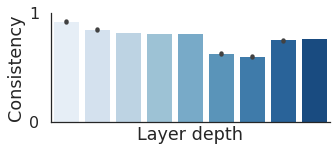

In [5]:
df_last_epoch = df[df['epoch'] == log_epochs[-1]]
# df_last_epoch.head()
x_name = 'layer_id'
y_name = '2nd_order_corr'
b_pals = sns.color_palette("Blues", n_colors = n_layers)

f, ax = plt.subplots(1,1, figsize = (5, 2))

sns.barplot(
    x=x_name, y=y_name, 
    palette = b_pals, 
    data=df_last_epoch, ax=ax
)
ax.set_ylim([0, 1])
ax.set_yticks([0, 1])
ax.set_yticklabels([0, 1])
ax.set_ylabel('Consistency')
ax.set_xlabel('Layer depth')
ax.set_xticks([])
sns.despine()

temp_path = '/tigress/qlu/logs/temp/'
fname = 'wRSM_2r_%s_%s_s.png' % (model_name, data_name)
f.savefig(os.path.join(temp_path, fname),  bbox_inches='tight', dpi = 200)